In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 

from pathlib import Path

In [ ]:
data = pd.read_csv(Path('data') / 'ice_cream.csv')
data.rename(columns={'DATE': 'date', 'IPN31152N': 'production'}, inplace=True)
data.date = pd.to_datetime(data.date)
data.set_index('date', inplace=True)
start_date = pd.to_datetime('2010-01-01')
data = data[start_date:]

plt.title('Ice Cream Production Year by Year')
plt.ylabel('production')
plt.xlabel('year')
for year in range(2010, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), 
                color='black',
                linestyle='--')
plt.plot(data.production)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot


# acf = plot_acf(data.production, lags=120) # 12 months * 10 years = 120 lags
autocorrelation_plot(data.production)

# Based on decaying ACF we're probably dealing with an autoregressive process 

In [ ]:
pacf = plot_pacf(data.production, method='ywm')

## Based on PACF we should start with an autoregressive model on lags 1, 2, 3, 10, 13

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split

# X = data.index.values
# y = data.production.values

train, test = data[:60].values, data[60:].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.1)

In [ ]:
from sklearn.metrics import mean_squared_error

model = AutoReg(train, lags=[1, 2, 3, 10, 13])
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
print('Coefficients: %s' % model_fit.params)

plt.plot(predictions, label='predictions')
plt.plot(test, label='true values')
plt.legend()
plt.show()
f'MSE: {mean_squared_error(predictions, test)}'

## now let's do the same thing assuming 12-months seasonality:

In [ ]:
model = AutoReg(train, lags=[1, 2, 3, 10, 13], seasonal=True, period=12)
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# print('Coefficients: %s' % len(model_fit.params))

plt.plot(predictions, label='predictions')
plt.plot(test, label='true values')
plt.legend()
plt.show()
f'MSE: {mean_squared_error(predictions, test)}'

In [ ]:
# bingo... looks better and the MSE is way lower

### Dickey Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

# augmented dickey-fuller (for AR models more comlex than AR1)

adf_test_value, p_value, used_lags, nobs, _, _ = adfuller(data['production'].values)
print(f'''adf statistic: {adf_test_value} (lower than zero means no unit-roots)
p value: {p_value}''')

In [ ]:
# let's try to retrain the model with the number of lags produced by the augmented dickey-fuller
# test

model = AutoReg(train, lags=used_lags, seasonal=True, period=12)
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# print('Coefficients: %s' % len(model_fit.params))

plt.plot(predictions, label='predictions')
plt.plot(test, label='true values')
plt.legend()
plt.show()

print(f'''MSE: {mean_squared_error(predictions, test)}
using "number of lags" from the aug-dickey-fuller test helped!''')

In [ ]:
# ARMA model 
from statsmodels.tsa.arima.model import ARIMA

for i in range(3, 14):
    model = ARIMA(train, order=(i, 0, 0)) # hyperparams are AR-lags, diff-size, and MA-window-size
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
    plt.title(f'AR{i}')
    plt.plot(predictions, label='predictions')
    plt.plot(test, label='true values')
    plt.legend()
    plt.show()
    print(f'''ARIMA MSE (AR{i}): {mean_squared_error(predictions, test)}''')

In [ ]:
model_fit.summary()

## Plot Residuals

In [ ]:
residuals = predictions - test.reshape(-1)
plt.title("Residuals")
plt.plot(residuals)
plt.hlines(y=np.mean(residuals), xmin=0, xmax=len(residuals), colors='aqua', 
           linestyles='--', lw=2, label=np.mean(residuals))
plt.legend()
plt.show()
np.mean(residuals) # residuals mean close to zero good sign of extracting all meaninful signal

In [ ]:
def generate_ar_process(lags: int, coefs: list[float], length: int) -> np.array:
    if len(coefs) != lags:
        raise ValueError(f'number of coefs ({len(coefs)}) must match lags: ({lags})')
        
    coefs = np.array(coefs)
    series = [np.random.normal() for _ in range(lags)] # generate first lags (normally distributed)
    
    for _ in range(length - lags):
        previous_values = series[-lags:][::-1] # take 'lags' values from in reversed order
        new_value = np.sum(np.array(previous_values) * coefs + np.random.normal())
        series.append(new_value)
    return np.array(series)

lags = 3
for coef in [0.1, 0.2, 0.33333, 0.334, 0.5]:
    coefs = [coef, coef, coef]
    generated_tseries = generate_ar_process(lags, coefs, 100)
    plt.title(f'''AR process with {lags} lags and coefs sum to: {sum(coefs)}
    adf statistic: {adfuller(generated_tseries)[0]}
    p value: {adfuller(generated_tseries)[1]}''')
    plt.plot(generated_tseries)
    plt.show()


### process remains stationary as long as sum of coefs is lower than 1
### when it's 1 and higher it gets a clean trend (trend-stationary?) 
### when it's significantly higher than 1 it become a smooth exponential 

# MA Models

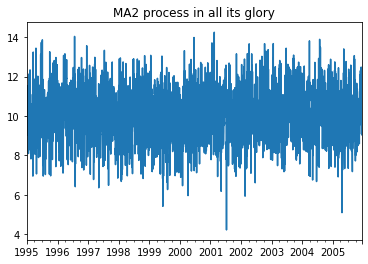

In [8]:
# generate MA process 

errors = np.random.normal(0, 1, 5000)

mu = 10
coef1 = 0.3333
coef2 = 0.1111
coef3 = 0.7
series = []
# generate MA2 process 
for t in range(1, 4002):
    series.append(mu + coef1*errors[t-1] + coef2*errors[t-2] + coef3*errors[t-3] + errors[t])

index = pd.date_range('1995-01-01', '2022-01-01')[:len(series)]
series = pd.Series(series, index=index)
series = series.asfreq(pd.infer_freq(series.index))
plt.title("MA2 process in all its glory")
series.plot()
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

test_size = 3 # for an MA3 model you can only predict 3 periods (converges to mean after that)
train, test = series[:-test_size].values, series[-test_size:].values
model = ARIMA(train, order=(0, 0, 3)) # pure MA3 model 
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
plt.title('MA3 Model')
plt.plot(predictions, label='predictions', color='r')
plt.plot(test, label='true values')
plt.legend()
plt.show()
model_fit.summary()

# S&P500 

In [ ]:
import yfinance 

spy_data = yfinance.Ticker('SPY')
spy_data = spy_data.history(period='1d', start='2010-01-01', end='2020-01-01')
closing_prices = spy_data[['Close']]
plt.title('SPY daily closing price')
plt.plot(closing_prices)
plt.show()

In [ ]:
daily_diffs = closing_prices.values[1:] - closing_prices[:-1]
plt.title('SPY daily movements')
plt.ylabel('Price difference')
plt.plot(daily_diffs)
for year in range(2010, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), linestyle='--', color='gray')
plt.show()

In [ ]:
acf_plot = plot_acf(daily_diffs, lags=100)

In [ ]:
pacf_plot = plot_pacf(daily_diffs, method='ywm')

# no significant autocorrelation (predict stock-market movements is not easy)

In [ ]:
def get_ticker_data(ticker: str, start_date: str = '1920-01-01', end_date: str = '2022-01-01', period='1d'):
    ticker_data = yfinance.Ticker(ticker)
    ticker_data = ticker_data.history(period='1d', start=start_date, end=end_date)
    if len(ticker_data) == 0:
        raise Exception(f'no data for: {ticker}')
    return ticker_data[['Close']]

In [ ]:
market_data = pd.DataFrame()
start, end = '2013-11-06','2021-01-01'
market_data['SPY'] = get_ticker_data('SPY', start_date=start, end_date=end)
market_data['DAX'] = get_ticker_data('DAX', start_date=start, end_date=end)
sse_index_tracking_fund = 'ASHR' #Xtrackers Hvst CSI 300 China A-Shs ETF
market_data[sse_index_tracking_fund] = get_ticker_data(sse_index_tracking_fund, start_date=start, end_date=end)
market_data.plot() # market_data.plot() and not plt.plot(market_data) to get labels automatically from cols
plt.legend()
plt.show()

In [ ]:
market_data.corr() # correlation between markets seems between ~62% end ~66%

In [ ]:
import scipy.stats as stats

def clean_mutual_nans(df: pd.DataFrame, col1: str, col2: str):
    return df[df[col2].notnull()][col1].dropna(), df[df[col1].notnull()][col2].dropna()

ashr, dax = clean_mutual_nans(market_data, 'ASHR', 'DAX')
r, p_value = stats.pearsonr(ashr, dax)
print('pearson r:', r, 'p value: ', p_value) 

r, p_value = stats.pearsonr(market_data.interpolate(method='time').fillna(method='bfill')['ASHR'],
                            market_data.interpolate(method='time').fillna(method='bfill')['DAX'])
print('(interpolated data) pearson r:', r, 'p value: ', p_value) 

In [ ]:
# plot moving averages
tsla_data = pd.DataFrame()
tsla_data['price'] = get_ticker_data('TSLA', start_date='2010-01-01', end_date='2022-01-01')
tsla_data['100d-MA'] = tsla_data['price'].rolling(100).mean()
tsla_data['200d-MA'] = tsla_data['price'].rolling(200).mean()
tsla_data.dropna()[-100:].plot()
plt.show()

In [ ]:
# moving average smoothing

spy_all_data = get_ticker_data('SPY', start_date='1993-01-01', end_date='2022-01-01')
for window in range(100, 1000, 100):
    plt.title(f'{window} moving average')
    ma_data = spy_all_data.rolling(window).mean().dropna()
    ma_data.plot()
    # reg_y = [pd.Timestamp(i).toordinal() for i in ma_data.index]
    # m, b = np.polyfit(reg_y, ma_data['Close'].values, 1)
    # x = np.array([1, 3, 5, 7])
    # plt.plot(x, x*m + b)
plt.show()

In [ ]:
volatility_data = get_ticker_data('VIX', start_date='2015-01-01', end_date='2018-01-01').apply(lambda x: x / 100)
volatility_data['SPY'] = get_ticker_data('SPY', start_date='2015-01-01', end_date='2018-01-01')
volatility_data.plot()
plt.show()

In [ ]:
def calc_roi(stock_price: pd.DataFrame):
    return stock_price.values[-1] / stock_price.values[0]

spy = get_ticker_data('SPY')
calc_roi(spy[pd.to_datetime('2020-12-01'):pd.to_datetime('2021-09-01')])

## search for TLCC: Time Lagged Cross Correlation — assessing signal dynamics

In [ ]:
spy, ashr = clean_mutual_nans(market_data, 'SPY', 'ASHR')
corr_df = pd.DataFrame()
for shift_periods in [10, 20, 30, 50]:
# shift_periods = 30
    corr_df['spy'] = spy
    corr_df['spy_shift'] = spy.shift(periods=shift_periods, freq='1D')
    corr_df['ashr'] = ashr
    corr_df['ashr_shift'] = ashr.shift(periods=shift_periods, freq='1D')
    assert corr_df.corr()['spy']['ashr_shift'] < corr_df.corr()['spy']['ashr']
    assert corr_df.corr()['ashr']['spy_shift'] < corr_df.corr()['ashr']['spy']
# doesn't look like there's some kind of TLCC...
corr_df.corr()

In [ ]:
assert corr_df.corr()['spy']['ashr_shift'] < corr_df.corr()['spy_shift']['ashr']
# also looks like more information is flowing from ashr to spy than the other way round 

In [ ]:
# compare securities functionality 
def compare_securities(tickers: list[str], normalize_prices=True, days_ago: int = None):
    raw_data = dict()
    for ticker in tickers:
        raw_data[ticker] = get_ticker_data(ticker)
    min_dates = []
    max_dates = []
    for df in raw_data.values():
        min_dates.append(df.index.min())
        max_dates.append(df.index.max())
    max_min = np.array(min_dates)[np.argmax(np.array(min_dates))]
    min_max = np.array(max_dates)[np.argmin(np.array(max_dates))]
    for ticker, data in raw_data.items():
        data = data[max_min:min_max]
        if days_ago is not None:
            data = data[pd.Timestamp.now() - pd.Timedelta(days=days_ago):]
        first_value = data['Close'].iloc[0].copy()
        ticker_df = pd.DataFrame()
        ticker_df['price'] = data['Close'].apply(lambda x: x / first_value) \
            if normalize_prices else data['Close']
        print(f'performance for "{ticker}": {(ticker_df.values[-1][0] / ticker_df.values[0][0]):.2f}X')
        plt.plot(ticker_df, label=ticker)
    plt.legend()
    plt.show()

In [ ]:
compare_securities(['TSLA', 'LCID', 'GM'])
compare_securities(['PLTR', 'HOOD', 'ARKK'])
compare_securities(['SPY', 'SPXL'], normalize_prices=False)
compare_securities(['SPY', 'SPXL'], normalize_prices=True)

In [ ]:
compare_securities(['TSLA', 'SPXL'])

In [ ]:
compare_securities(['SPXL', 'SSO', 'SPY'], days_ago=365)

In [ ]:
compare_securities(['ARKK', 'IPO'])

In [ ]:
compare_securities(['BTC-USD', 'ETH-USD', 'TSLA', 'SPXL']) # crazy bets comparison 

performance for "NVDA": 2.45X
performance for "TSLA": 1.95X


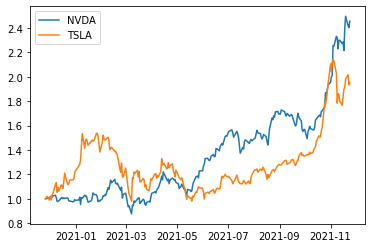

In [154]:
compare_securities(['NVDA', 'TSLA'], days_ago=365)